<a href="https://colab.research.google.com/github/JadHay8/CIFAR100-Classification-Challenge/blob/main/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
! pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jadhaytaoglu","key":"49c0cf9ae42138b58267840699069139"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

! kaggle competitions download -c cifar-challenge-classify-the-world-of-objects

! mkdir cifar-challenge-classify-the-world-of-objects
! unzip cifar-challenge-classify-the-world-of-objects.zip -d cifar-challenge-classify-the-world-of-objects

ref                                                           title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
bhadramohit/customer-shopping-latest-trends-dataset           Customer Shopping (Latest Trends) Dataset      76KB  2024-11-23 15:26:12           4647         92  1.0              
ikynahidwin/depression-student-dataset                        Depression Student Dataset                      4KB  2024-11-20 06:42:01           3916         73  1.0              
steve1215rogg/student-lifestyle-dataset                       student lifestyle dataset                      22KB  2024-11-11 19:11:28           7364        121  1.0              
mohitkumar282/used-car-dataset                                Used Car Dataset                      

In [ ]:
# Importing necessary libraries

import torch  # Core PyTorch library for tensor operations
from torchvision import datasets, transforms  # Datasets and transformations for computer vision
import torch.nn as nn  # Neural network components
import torch.optim as optim  # Optimization algorithms
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plotting
from torch.utils.data import DataLoader, Dataset, random_split, Subset  # Data handling utilities

# Retrieving Images from test.csv

Total samples in CSV: 10000


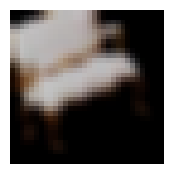

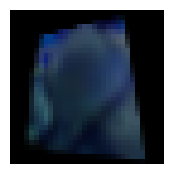

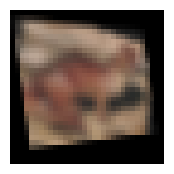

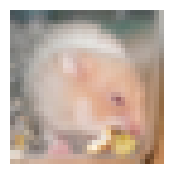

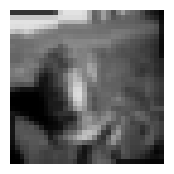

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

csv_path = 'cifar-challenge-classify-the-world-of-objects/test.csv'
df = pd.read_csv(csv_path)

print(f"Total samples in CSV: {len(df)}")

# Function to reverse the normalization
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

# Select a few samples to display (e.g., first 5)
num_samples = 5
samples = df.sample(n=num_samples)  # Randomly select samples for diversity

# Iterate through the selected samples and display images
for index, row in samples.iterrows():
    # Extract pixel data and convert to numpy array
    pixel_data = row[[f'pixel_{i}' for i in range(1, 3073)]].values.astype(np.float32)

    # Reshape to (3, 32, 32)
    image = pixel_data.reshape(3, 32, 32)

    # Convert to torch tensor
    image_tensor = torch.tensor(image)

    # Reverse the normalization
    image_tensor = unnormalize(image_tensor, cifar100_mean, cifar100_std)

    # Clip the values to [0, 1] range
    image_tensor = torch.clamp(image_tensor, 0, 1)

    # Convert to numpy array and transpose to (32, 32, 3) for plotting
    image_np = image_tensor.numpy().transpose(1, 2, 0)

    # Convert to PIL Image for better handling (optional)
    image_pil = Image.fromarray((image_np * 255).astype(np.uint8))

    # Display the image using matplotlib
    plt.figure(figsize=(2,2))
    plt.imshow(image_pil)
    plt.axis('off')


# Label Map

In [ ]:
cifar100_label_names = [
    "apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle", "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", "caterpillar", "cattle", "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur", "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo", "keyboard", "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain", "mouse", "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree", "plain", "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider", "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone", "television", "tiger", "tractor", "train", "trout", "tulip", "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"
]
label_mapping_df = pd.DataFrame({
    'LABEL': range(100),
    'Class Name': cifar100_label_names
})
# Display the first few rows of the DataFrame
print(label_mapping_df.head())


   LABEL     Class Name
0      0          apple
1      1  aquarium_fish
2      2           baby
3      3           bear
4      4         beaver


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


# Fetching the CIFAR-100 Training and Testing Data

Hyper Parameters

In [ ]:
batch_size = 64           # Batch size for data loading
learning_rate = 0.01      # Learning rate for optimizer
num_epochs = 200           # Number of training epochs

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define the transformations for the dataset (you can modify this as needed)
train_transform = transforms.Compose([
      ###### Add your transformations here ########
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAdjustSharpness(sharpness_factor=1.8, p=0.4),
    # transforms.RandomAutocontrast(p=0.4),
    # transforms.RandomPerspective(distortion_scale=0.1),
    # transforms.RandomSolarize(128),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# Download the CIFAR-100 training dataset
train_dataset = datasets.CIFAR100(
    root='./data',       # Change this path if needed
    train=True,          # Set to True to download the training set
    download=True,       # Set to True to download if not already downloaded
    transform=train_transform  # Apply transformations
)

# Create a DataLoader for batch processing
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,      # Batch size (you can modify this as needed)
    shuffle=True,           # Shuffle data for training
    num_workers=2           # Number of worker processes for data loading
)


# Download the CIFAR-100 testing dataset
test_dataset = datasets.CIFAR100(
    root='./data',       # Change this path if needed
    train=False,
    download=True,       # Set to True to download if not already downloaded
    transform=test_transform  # Apply transformations
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

# Example: Accessing one batch of images and labels
# images, labels = next(iter(train_loader))
# print(f"Batch of images shape: {images.shape}")
# print(f"Batch of labels: {labels}")


Files already downloaded and verified
Files already downloaded and verified


# Building Model (not used - scroll down)

In [ ]:
# did not end up using this model
class CIFAR100Classifier(nn.Module):
    def __init__(self):
        super(CIFAR100Classifier, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)

        # Max pooling and Global Average Pooling (GAP)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        # Input size matches GAP output
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 100)  # 100 classes for CIFAR100

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolutional layers with batch normalization, ReLU, and pooling
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        x = self.relu(self.bn6(self.conv6(x)))  # No pooling after conv5

        # Global Average Pooling
        x = self.gap(x)
        x = torch.flatten(x, start_dim=1)

        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.fc4(x)

        return x

# ResNet Model (used)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity  # Add the shortcut connection
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()

        # Residual blocks
        self.resblock1 = ResidualBlock(32, 64, stride=2)  # Downsample
        self.resblock2 = ResidualBlock(64, 128, stride=2)  # Downsample
        self.resblock3 = ResidualBlock(128, 256, stride=2)  # Downsample
        self.resblock4 = ResidualBlock(256, 512, stride=2)  # Downsample
        self.resblock5 = ResidualBlock(512, 1024, stride=2)  # Downsample

        # Global Average Pooling (GAP)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 100)  # 100 classes for CIFAR100

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Initial convolution
        x = self.relu(self.bn1(self.conv1(x)))

        # Residual blocks
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)

        # Global Average Pooling
        x = self.gap(x)
        x = torch.flatten(x, start_dim=1)

        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.fc4(x)

        return x




# Train Model

In [ ]:
# Initialize model and move to device
# model = CIFAR100Classifier()
model = ResNet()
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropy includes softmax
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Adjust as needed

# Scheduler for dynamic learning rate
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=num_epochs
)

In [ ]:
# function to evaluate model on test dataset
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total_samples += targets.size(0)

    average_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples * 100

    return accuracy, average_loss

In [ ]:
# Training the model
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0.0
    correct = 0
    total_samples = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)

    scheduler.step()

    # Evaluate on train and test sets after each epoch

    # Calculate average loss and accuracy for the epoch
    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total_samples * 100

    # Evaluate on test set
    test_accuracy, test_loss = evaluate(model, test_loader, criterion)



    print(f'Epoch {epoch+1:02d}/{num_epochs:02d} - Train Loss: {train_loss:.6f}, Train Acc: {train_accuracy:.2f}%')
    print(f'            - Test Loss: {test_loss:.6f}, Test Acc: {test_accuracy:.2f}%')
    print(f"            - Current Learning Rate: {scheduler.get_last_lr()}")
    print("-" * 60)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

torch.save(model.state_dict(), 'model.pth')

NameError: name 'num_epochs' is not defined

# Get test.csv Test Data

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

test_data = pd.read_csv('cifar-challenge-classify-the-world-of-objects/test.csv')

ids = test_data['ID']
pixels = test_data.drop(columns=['ID']).values
pixels = pixels.reshape(-1, 3, 32, 32)
pixels_tensor = torch.stack([torch.tensor(img, dtype=torch.float32) for img in pixels])
test_dataset = TensorDataset(pixels_tensor)

# Create a DataLoader for batch processing
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
)

NameError: name 'pd' is not defined

# Get Predictions

In [ ]:
model = ResNet()
model.to(device)
state_dict = torch.load("model.pth")  # Load the state_dict
model.load_state_dict(torch.load('model.pth', map_location=device))

model.eval()  # Set model to evaluation mode

predictions = []

with torch.no_grad():  # No gradient calculation for evaluation
    for batch in test_loader:
        # inputs, targets = inputs.to(device), targets.to(device)
        inputs = batch[0].float().to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.cpu().numpy())





<ipython-input-67-3dc84b02ab9b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("model.pth")  # Load the state_dict
<ipython-input-67-3dc84b02ab9b>:

# Create Output File

In [ ]:
import csv

# Define the output file path
output_csv_path = "submission.csv"

# Create DataFrame for the predictions
submission_df = pd.DataFrame({
    "ID": ids,
    "LABEL": predictions
})

submission_df.to_csv(output_csv_path, index=False)


# Plotting Loss

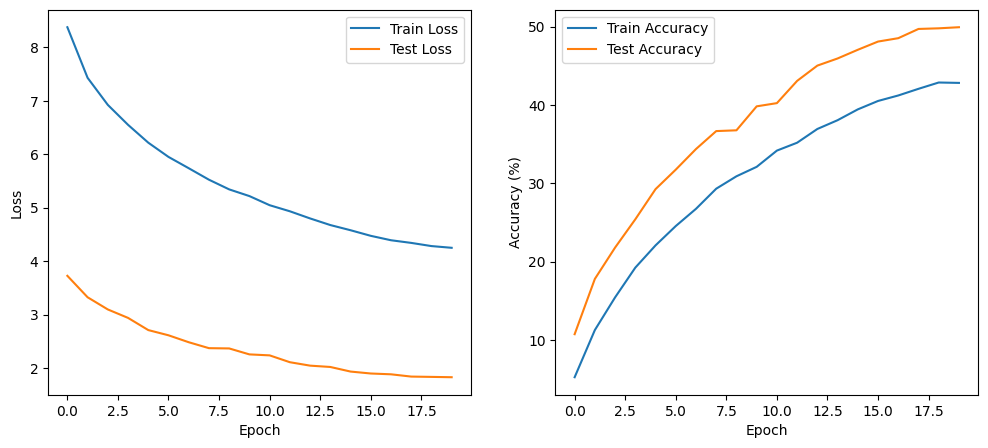

In [ ]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()